## Parking Lot Questions:
1) Should I be using LeakyReLU instead of ReLU?
2) What does batch normalization actually do?
3) How do we determine what size of convolutions to use for UNet? Are we simply picking ones that reduce our output size?

# Imports

In [118]:
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
from torchvision import datasets, transforms

In [119]:
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace       # hybrid frontend decorator and tracing jit

In [120]:
import os
import pandas
import glob
from PIL import Image
import time

import matplotlib.pyplot as plt
import numpy as np

## Hyperparameters

In [121]:
# Model hyperparameters

## Batch Size
TRAIN_BATCH_SIZE = 1
TEST_BATCH_SIZE = 1

## Learning Rate
LEARNING_RATE = 0.001

# Epochs
NUM_EPOCHS = 10

# Data

In [122]:
monet_filelist = glob.glob("data/monet_jpg/*.jpg")
photo_filelist = glob.glob("data/photo_jpg/*.jpg")

monet_data_array = np.array([np.array(Image.open(file_name)) for file_name in monet_filelist])
photo_data_array = np.array([np.array(Image.open(file_name)) for file_name in photo_filelist])

In [123]:
class ImageDataset(Dataset):

    def __init__(
        self,
        data_array,
        transform=None
    ) -> None:
        super().__init__()

        self.transform = transform
        self.data_array = data_array

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image = self.data_array[index]

        if self.transform:
            image = self.transform(image)

        return image


In [124]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
])
monet_dataset = ImageDataset(data_array=monet_data_array, transform=transform)
photo_dataset = ImageDataset(data_array=photo_data_array, transform=transform)

<class 'torch.Tensor'>
torch.Size([3, 256, 256])


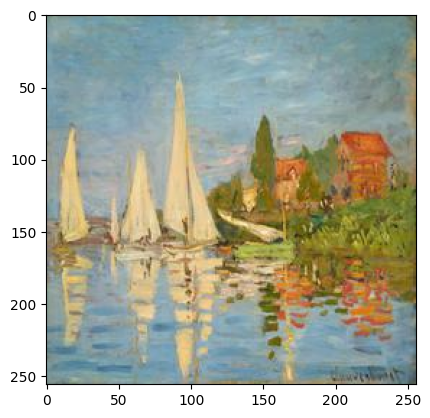

In [125]:
print(type(monet_dataset[0]))
print(monet_dataset[0].shape)
plt.imshow(monet_dataset[0].numpy().transpose(1, 2, 0))

<class 'torch.Tensor'>
torch.Size([3, 256, 256])


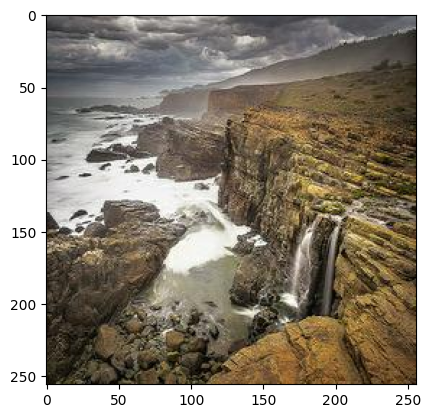

In [126]:
print(type(photo_dataset[0]))
print(photo_dataset[0].shape)
plt.imshow(photo_dataset[0].numpy().transpose(1, 2, 0))

In [127]:
monet_train_dataloader = DataLoader(monet_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
photo_train_dataloader = DataLoader(photo_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

# Model

In [128]:
def get_output_size(
    input_height: int, input_width: int,
    kernel_size: int, padding: int, stride: int,
    output_channels: int,
    ):
    output_height = int(((input_height + 2 * padding - (kernel_size - 1) - 1) / stride) + 1)
    output_width = int(((input_width + 2 * padding - (kernel_size - 1) - 1) / stride) + 1)
    return (output_height, output_width, output_channels)

In [129]:
# downsample function: takes number of input and output channels and returns a Conv2D layer
def downsample(in_channels: int, out_channels: int):

    kernel_size = 4
    stride = 2
    padding = 1

    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(),
    )


In [130]:
def upsample(in_channels: int, out_channels: int):

    kernel_size = 4
    stride = 2
    padding = 1

    return nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU()
    )

In [131]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.downsample_1 = downsample(in_channels=3, out_channels=64) 
        self.downsample_2 = downsample(in_channels=64, out_channels=128)
        self.downsample_3 = downsample(in_channels=128, out_channels=256)
        self.downsample_4 = downsample(in_channels=256, out_channels=512) 
        self.downsample_5 = downsample(in_channels=512, out_channels=1024)
        self.downsample_6 = downsample(in_channels=1024, out_channels=2048)
        self.downsample_7 = downsample(in_channels=2048, out_channels=4096)
        # self.downsample_8 = downsample(in_channels=4096, out_channels=8192)

        # self.upsample_1 = upsample(in_channels=8192, out_channels=4096)
        self.upsample_2 = upsample(in_channels=4096, out_channels=2048)
        self.upsample_3 = upsample(in_channels=4096, out_channels=1024)
        self.upsample_4 = upsample(in_channels=2048, out_channels=512)
        self.upsample_5 = upsample(in_channels=1024, out_channels=256)
        self.upsample_6 = upsample(in_channels=512, out_channels=128)
        self.upsample_7 = upsample(in_channels=256, out_channels=64)
        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=3),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor):
        ds1_out = self.downsample_1(x) # (bs, 128, 128, 64)
        ds2_out = self.downsample_2(ds1_out) # (bs, 64, 64, 128)
        ds3_out = self.downsample_3(ds2_out) # (bs, 32, 32, 256)
        ds4_out = self.downsample_4(ds3_out) # (bs, 16, 16, 512)
        ds5_out = self.downsample_5(ds4_out) # (bs, 8, 8, 1024)
        ds6_out = self.downsample_6(ds5_out) # (bs, 4, 4, 2048)
        ds7_out = self.downsample_7(ds6_out) # (bs, 2, 2, 4096)
        # (Hin−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1

        out = torch.cat((self.upsample_2(ds7_out), ds6_out), dim=1) # (bs, 4, 4, 4096)
        out = torch.cat((self.upsample_3(out), ds5_out), dim=1) # (bs, 8, 8, 2048)
        out = torch.cat((self.upsample_4(out), ds4_out), dim=1) # (bs, 16, 16, 1024)
        out = torch.cat((self.upsample_5(out), ds3_out), dim=1) # (bs, 32, 32, 512)
        out = torch.cat((self.upsample_6(out), ds2_out), dim=1) # (bs, 64, 64, 256)
        out = torch.cat((self.upsample_7(out), ds1_out), dim=1) # (bs, 128, 128, 128)
        out = self.last(out) # (bs, 256, 256, 3)

        return out
        ## NOTE: Nothing gets concatenated to this output layer

In [132]:
monet_generator = Generator()

monet_gen_out = monet_generator(monet_dataset[0].reshape(1, 3, 256, 256))

In [133]:
def disc_downsample(in_channels: int, out_channels: int):

    kernel_size = 4
    stride = 2
    padding = 1

    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )

In [134]:
class Discriminator(nn.Module):

    def __init__(self) -> None:
        super(Discriminator, self).__init__()
        self.downsample_1 = disc_downsample(in_channels=3, out_channels=64) 
        self.downsample_2 = disc_downsample(in_channels=64, out_channels=128) 
        self.downsample_3 = disc_downsample(in_channels=128, out_channels=256) 
        self.last = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x: torch.Tensor):
        out = self.downsample_1(x) #(bs, 64, 128, 128)
        out = self.downsample_2(out) #(bs, 128, 64, 64)
        out = self.downsample_3(out) #(bs, 256, 32, 32)
        out = self.last(out) # (bs, 1, 30, 30)

        return out

In [135]:
monet_discriminator = Discriminator()

monet_disc_out = monet_discriminator(monet_gen_out)
print(monet_disc_out.shape)

torch.Size([1, 1, 30, 30])


In [164]:
def discriminator_loss(real, generated):
    real_loss = F.binary_cross_entropy_with_logits(torch.ones_like(real), real)

    generated_loss = F.binary_cross_entropy_with_logits(torch.ones_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    # Average them
    return total_disc_loss * 0.5

A matrix of all ones indicates that photo is real. So, the generator, wanting to trick the discriminator, will compare the discriminator's output for the generated image to a matrix of 1s in order to see how well it tricked it.

In [165]:
def generator_loss(generated):
    return F.binary_cross_entropy_with_logits(torch.ones_like(generated), generated)

In [166]:
def cycle_loss(real, cycled, lambda_cycle):
    c_loss = torch.mean(torch.abs(real - cycled))

    return lambda_cycle * c_loss

In [167]:
def identity_loss(real, generated, lambda_cycle):
    i_loss = torch.mean(torch.abs(real - generated))

    return lambda_cycle * 0.5 * i_loss

In [178]:
class CycleGan(nn.Module):

    def __init__(
        self,
        monet_gen,
        photo_gen,
        monet_disc,
        photo_disc,
        lambda_cycle=10
    ) -> None:
        super(CycleGan, self).__init__()

        self.monet_gen = monet_gen
        self.photo_gen = photo_gen
        self.monet_disc = monet_disc
        self.photo_disc = photo_disc
        
        self.optimizer = torch.optim.Adam(self.parameters(),lr=LEARNING_RATE)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.1)

        self.lambda_cycle = lambda_cycle

        self.disc_loss_fn = discriminator_loss
        self.gen_loss_fn = generator_loss
        self.cycle_loss_fn = cycle_loss
        self.identity_loss_fn = identity_loss

    def init_weights(self, layer):
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.BatchNorm2d):
            torch.nn.init.normal(layer, mean=0.0, std=0.2)

    def forward(self, photo_batch, monet_batch):
        # photo -> monet -> photo
        fake_monet = self.monet_gen(photo_batch)
        cycled_photo = self.photo_gen(fake_monet)

        # monet -> photo -> monet
        fake_photo = self.photo_gen(monet_batch)
        cycled_monet = self.monet_gen(fake_photo)

        # monet -> monet, photo -> photo
        identity_monet = self.monet_gen(monet_batch)
        identity_photo = self.photo_gen(photo_batch)

        # discrminator output on real images
        disc_real_monet = self.monet_disc(monet_batch)
        disc_real_photo = self.photo_disc(photo_batch)

        # discriminator output on fake images
        disc_fake_monet = self.monet_disc(fake_monet)
        disc_fake_photo = self.photo_disc(fake_photo)

        return monet_batch, photo_batch, cycled_monet, cycled_photo, identity_monet, identity_photo, \
                disc_real_monet, disc_real_photo, disc_fake_monet, disc_fake_photo

    def calculate_loss(
        self,
        monet_batch,
        photo_batch,
        cycled_monet,
        cycled_photo,
        identity_monet,
        identity_photo,
        disc_real_monet,
        disc_real_photo,
        disc_fake_monet,
        disc_fake_photo
    ):
        # total cycle loss
        total_cycle_loss = \
            self.cycle_loss_fn(real=monet_batch, cycled=cycled_monet, lambda_cycle=self.lambda_cycle) \
            + self.cycle_loss_fn(real=photo_batch, cycled=cycled_photo, lambda_cycle=self.lambda_cycle)

        # total generator losses
        monet_gen_loss = \
            self.gen_loss_fn(generated=disc_fake_monet) \
            + self.identity_loss_fn(real=monet_batch, generated=identity_monet, lambda_cycle=self.lambda_cycle) \
            + total_cycle_loss
        photo_gen_loss = \
            self.gen_loss_fn(generated=disc_fake_photo) \
            + self.identity_loss_fn(real=photo_batch, generated=identity_photo, lambda_cycle=self.lambda_cycle) \
            + total_cycle_loss

        # total discriminator loss
        monet_disc_loss = self.disc_loss_fn(real=disc_real_monet, generated=disc_fake_monet)
        photo_disc_loss = self.disc_loss_fn(real=disc_real_photo, generated=disc_fake_photo)

        return monet_gen_loss, photo_gen_loss, monet_disc_loss, photo_disc_loss

    def train_step(self, photo_batch, monet_batch):
        self.optimizer.zero_grad()

        outputs = self.forward(photo_batch=photo_batch, monet_batch=monet_batch)

        monet_gen_loss, photo_gen_loss, \
            monet_disc_loss, photo_disc_loss = self.calculate_loss(*outputs)

        monet_gen_loss.backward()
        photo_gen_loss.backward(retain_graph=True)

        monet_disc_loss.backward(retain_graph=True)
        photo_disc_loss.backward(retain_graph=True)

        self.optimizer.step()

        return monet_gen_loss, photo_gen_loss, monet_disc_loss, photo_disc_loss


        

# Training

In [179]:
monet_gen = Generator()
photo_gen = Generator()
monet_disc = Discriminator()
photo_disc = Discriminator()

In [180]:
cycle_gan = CycleGan(
    monet_gen=monet_gen,
    photo_gen=photo_gen,
    monet_disc=monet_disc,
    photo_disc=photo_disc
)

In [181]:
def init_weights(layer):
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.BatchNorm2d):
        torch.nn.init.normal_(layer.weight.data, mean=0.0, std=0.2)

cycle_gan.apply(init_weights)

CycleGan(
  (monet_gen): Generator(
    (downsample_1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (downsample_2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (downsample_3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (downsample_4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (downsample_5): Sequential(
      (0): Conv2d(512, 1024, 

In [182]:
print("Start training")
loss_array = []

cycle_gan.train()
for epoch in range(NUM_EPOCHS):
    print(f"\nStarting epoch {epoch+1} of {NUM_EPOCHS}\n")

    start_time = time.time()
    for photo, monet in zip(photo_train_dataloader, monet_train_dataloader):
        losses = cycle_gan.train_step(photo_batch=photo, monet_batch=monet)
        loss_array.append(losses)

    end_time = time.time()
    print(f"Epoch {epoch} completed in: {end_time - start_time}")


Start training

Starting epoch 1 of 10



RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
# from pylab import plot, title, xlabel, ylabel, savefig, legend, array

# values = [(3, 4, 5), (7, 8, 9), (2, 3, 4)]
# days = array([24, 25, 26])

# for temp in zip(*values):
#     plot(days, array(temp))
# title('Temperature at december')
# xlabel('Days of december')
# ylabel('Temperature')
# legend(['min', 'avg', 'max'], loc='lower center')
# savefig("temperature_at_christmas.pdf")